# Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from math import sqrt

from rdkit import Chem
from rdkit.Chem import AllChem, Draw, PandasTools, Descriptors
from rdkit.Chem.rdmolops import GetAdjacencyMatrix
from rdkit.Chem.Draw import IPythonConsole

from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch.utils.data import random_split

from torch_geometric.data import Data, InMemoryDataset, download_url, extract_gz
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx, from_smiles
from torch_geometric.nn import AttentiveFP

from sklearn.metrics import r2_score

import os
import random
from collections import Counter

In [27]:
plt.style.use('ggplot')

In [2]:
def global_seed(seed=2):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

In [3]:
global_seed()

### Dataset

In [4]:
df = pd.read_csv('Data/Lipophilicity.csv')
df.head()

,CMPD_CHEMBLID,exp,smiles
0,CHEMBL596271,3.54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14
1,CHEMBL1951080,-1.18,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...
2,CHEMBL1771,3.69,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl
3,CHEMBL234951,3.37,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...
4,CHEMBL565079,3.10,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...


In [8]:
df.describe()

,exp
count,4200.000000
mean,2.186336
std,1.203004
min,-1.500000
25%,1.410000
50%,2.360000
75%,3.100000
max,4.500000


In [9]:
df['smiles'].nunique()

4200

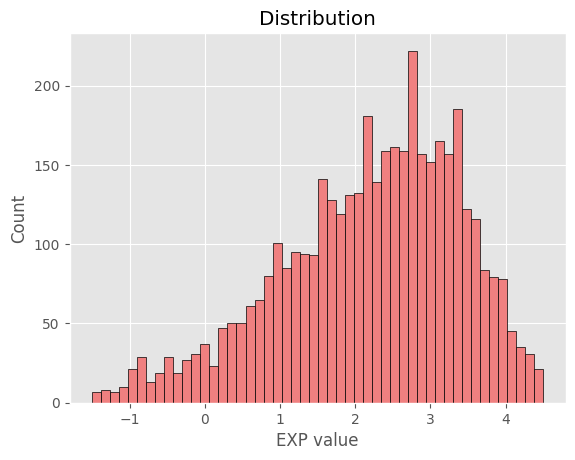

In [30]:
plt.hist(x=df['exp'], bins=50, edgecolor='black', linewidth=0.5, color='lightcoral')
plt.title('Distribution')
plt.xlabel('EXP value')
plt.ylabel('Count')
plt.show()

#### Creating Mol object from smiles representation

In [5]:
PandasTools.AddMoleculeColumnToFrame(df, smilesCol='smiles', molCol='mol')
df.head()

,CMPD_CHEMBLID,exp,smiles,mol
0,CHEMBL596271,3.54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14,<rdkit.Chem.rdchem.Mol object at 0x000002DE94B...
1,CHEMBL1951080,-1.18,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...,<rdkit.Chem.rdchem.Mol object at 0x000002DEA66...
2,CHEMBL1771,3.69,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl,<rdkit.Chem.rdchem.Mol object at 0x000002DEA66...
3,CHEMBL234951,3.37,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...,<rdkit.Chem.rdchem.Mol object at 0x000002DEA66...
4,CHEMBL565079,3.10,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...,<rdkit.Chem.rdchem.Mol object at 0x000002DEA66...


#### Extracting molecular weight

In [6]:
df['mol_wt'] = df['mol'].apply(Descriptors.MolWt)
df.head()

,CMPD_CHEMBLID,exp,smiles,mol,mol_wt
0,CHEMBL596271,3.54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14,<rdkit.Chem.rdchem.Mol object at 0x000002DE94B...,340.858
1,CHEMBL1951080,-1.18,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...,<rdkit.Chem.rdchem.Mol object at 0x000002DEA66...,494.591
2,CHEMBL1771,3.69,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl,<rdkit.Chem.rdchem.Mol object at 0x000002DEA66...,321.829
3,CHEMBL234951,3.37,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...,<rdkit.Chem.rdchem.Mol object at 0x000002DEA66...,419.890
4,CHEMBL565079,3.10,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...,<rdkit.Chem.rdchem.Mol object at 0x000002DEA66...,381.480


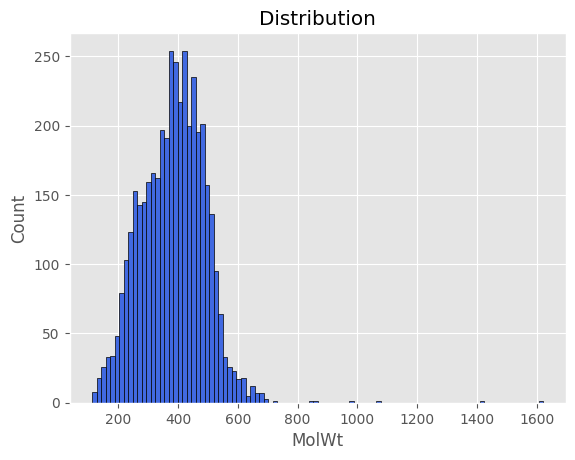

In [29]:
plt.hist(x=df['mol_wt'], bins=100, edgecolor='black', linewidth=0.5, color='royalblue')
plt.title('Distribution')
plt.xlabel('MolWt')
plt.ylabel('Count')
plt.show()

#### Let's take a look at molecules with high molecular weight

In [ ]:
import requests

def get_molecule_names(chembl_ids):
    base_url = "https://www.ebi.ac.uk/chembl/api/data/molecule.json"
    
    params = {
        'molecule_chembl_id__in': ','.join(chembl_ids),
        'limit': len(chembl_ids) 
    }

    response = requests.get(base_url, params=params)

    if response.status_code == 200:
        data = response.json().get('molecules', [])
        return {item['molecule_chembl_id']: item.get('pref_name') for item in data}
    else:
        return {}

In [8]:
high_mol_wt = df.loc[df['mol_wt'] > 700].copy()

# Extract ChEMBL IDs and request molecule names
chembl_ids = high_mol_wt['CMPD_CHEMBLID'].unique().tolist()
mol_name_map = get_molecule_names(chembl_ids)

# Map the results back to the DataFrame
high_mol_wt['mol_name'] = high_mol_wt['CMPD_CHEMBLID'].map(mol_name_map)

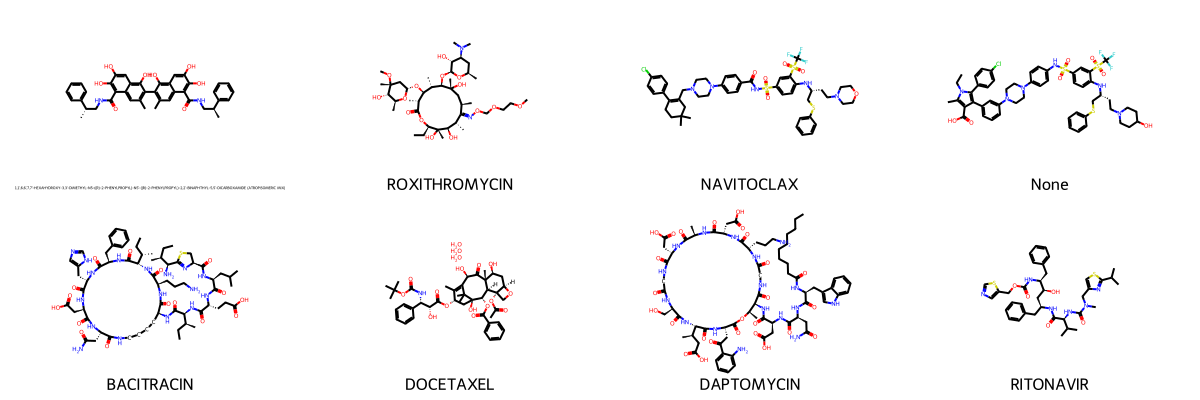

In [9]:

img = Draw.MolsToGridImage(high_mol_wt['mol'], molsPerRow=4, subImgSize=(300, 200), legends=[str(x) for x in high_mol_wt['mol_name']])
img

#### Removing outliers (molecules with high molecular weight)

In [15]:
high_mol_wt_smiles = high_mol_wt['smiles']
df_final = df[~df['smiles'].isin(high_mol_wt_smiles)]
df_final = df_final.reset_index(drop=True)
df_final.shape

(4192, 5)

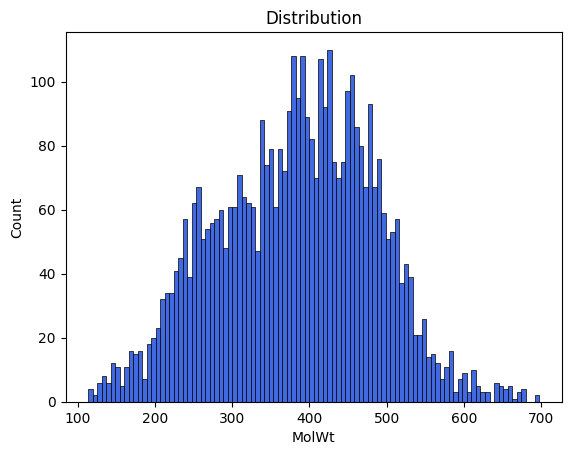

In [16]:
plt.hist(x=df_final['mol_wt'], bins=100, edgecolor='black', linewidth=0.5, color='royalblue')
plt.title('Distribution')
plt.xlabel('MolWt')
plt.ylabel('Count')
plt.show()

### Unique Atoms    

In [22]:
unique_atoms = {}
for mol in df_final['mol']:
    for atom in mol.GetAtoms():
        atom_symbol = atom.GetSymbol()
        if atom_symbol not in unique_atoms:
            unique_atoms[atom_symbol] = 1
        else:
            unique_atoms[atom_symbol] += 1


In [23]:
unique_atoms

{'C': 83065,
 'N': 14505,
 'Cl': 1288,
 'O': 10679,
 'S': 1580,
 'F': 1760,
 'B': 6,
 'Br': 100,
 'P': 3,
 'I': 7,
 'Si': 1,
 'Se': 1}

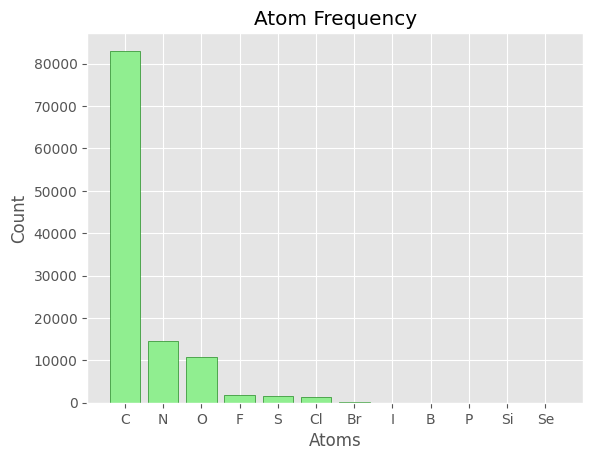

In [36]:
atom_freq = pd.DataFrame(unique_atoms.items(), columns=['Atom', 'Count']).sort_values('Count', ascending=False)
plt.bar(x=atom_freq['Atom'], height=atom_freq['Count'], color='lightgreen', edgecolor='forestgreen')
plt.title('Atom Frequency')
plt.xlabel('Atoms')
plt.ylabel('Count')
plt.show()